## Inverse Transform Sampling - Code Recipe

[Original repository on GitHub](https://github.com/Hvass-Labs/Code-Recipes)

Original author is [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

## Introduction

Generate random numbers using Inverse Transform Sampling which works for most Probability Density Functions (PDF) and Cumulative Distribution Functions (CDF).

## Google Colab

In [1]:
# Is this running in Google Colab?
if 'google.colab' in str(get_ipython()):
    # Install all the required Python packages.
    %pip install numpy matplotlib

## Imports

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Config

In [3]:
# Plot size.
plt.rcParams["figure.figsize"] = (20,5)

## Function

In [4]:
def pdf_to_cdf(pdf_points, pdf_values, num=None):
    """
    Convert a Probability Density Function (PDF) to a Cumulative Distribution
    Function (CDF), which can be used for efficient sampling of random numbers
    using the function `rand_from_cdf`.

    :param pdf_points: PDF points on the x-axis.
    :param pdf_values: PDF values on the y-axis.
    :param num:
        Int with number of CDF points. Use linear interpolation of PDF arrays
        to avoid "stair-case" in random numbers. Use `None` for no resampling.
    :return:
        cdf_points: Array with CDF points on the x-axis.
        cdf_values: Array with CDF values evaluated at `cdf_points`.
    """
    # Upsample the PDF array?
    if num is not None and len(pdf_points) < num:
        # Use evenly spaced points on x-axis.
        cdf_points = np.linspace(pdf_points[0], pdf_points[-1], num=num)

        # Upsample PDF using linear interpolation.
        pdf_values = np.interp(cdf_points, xp=pdf_points, fp=pdf_values)
    else:
        # Use the PDF points for the CDF as well.
        cdf_points = pdf_points
    
    # Normalize CDF so it starts at 0.0 and ends at 1.0
    cdf_values = np.cumsum(pdf_values)
    cdf_values -= cdf_values[0]
    cdf_values /= cdf_values[-1]
    
    return cdf_points, cdf_values

In [5]:
def rand_from_cdf(rng, cdf_points, cdf_values, size):
    """
    Generate random numbers using a Cumulative Distribution Function (CDF),
    which is estimated using linear interpolation from the input arrays.

    This uses Inverse Transform Sampling of the CDF:
    https://en.wikipedia.org/wiki/Inverse_transform_sampling

    :param rng: Instance of `numpy.random.default_rng`.
    :param cdf_points: Sorted array of data-points where the CDF is estimated.
    :param cdf_values: Array with the CDF-values corresponding to `cdf_points`.
    :param size: Shape of the output array.
    :return: Array with random numbers drawn from the given CDF.
    """
    # Draw random uniform numbers from [0,1) used in the "reverse-lookup".
    x = rng.uniform(0.0, 1.0, size=size)

    # Get the actual random numbers by a "reverse-lookup" of the CDF-values.
    # Note how points and values are switched in the interpolation function.
    samples = np.interp(x=x, xp=cdf_values, fp=cdf_points)
    
    return samples

## Test

In [6]:
# Random Number Generator (RNG).
rng = np.random.default_rng(seed=1234)

# Sample size.
size = 100_000

# PDF points on the x-axis.
pdf_points = np.array([1, 1.5, 2, 2.1, 2.4, 2.5, 3, 3.01, 3.02])

# PDF values on the y-axis. Normalized so they sum to 1.
pdf_values = np.array([0.7, 0.5, 1.0, 0.0, 0.0, 0.5, 0.0, 1.0, 0.0])
pdf_values /= pdf_values.sum()

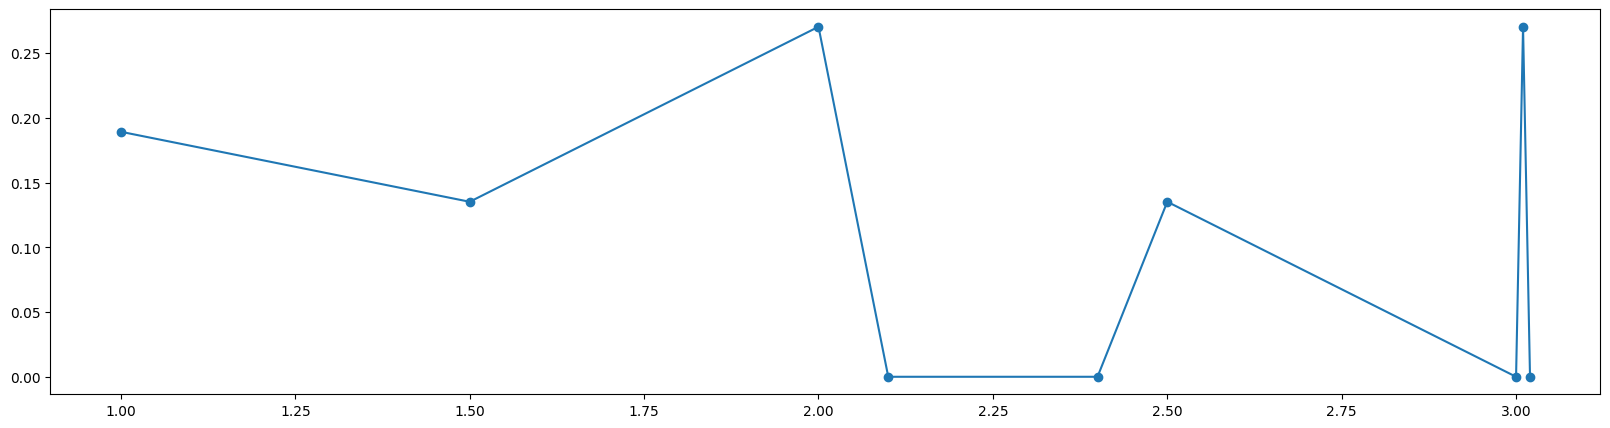

In [7]:
# Plot the PDF.
plt.plot(pdf_points, pdf_values);
plt.scatter(pdf_points, pdf_values);

In [8]:
# Convert PDF to CDF. This first interpolates the PDF at regular intervals,
# so the random samples don't look like a "stair-case". Because there is a
# narrow spike in the original PDF, we need a large number of points in the
# CDF, to ensure the narrow spike is included.
cdf_points, cdf_values = \
    pdf_to_cdf(pdf_points=pdf_points, pdf_values=pdf_values, num=200)

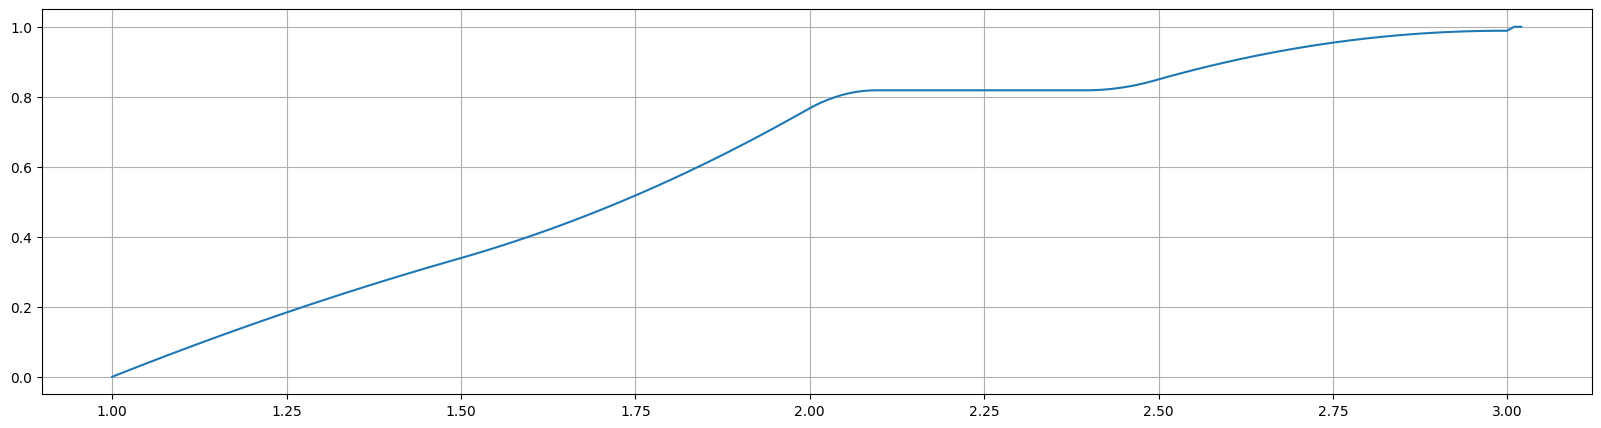

In [9]:
# Plot the CDF.
plt.plot(cdf_points, cdf_values);
plt.grid();

In [10]:
# Generate random samples from our CDF.
samples = rand_from_cdf(rng=rng, cdf_points=cdf_points,
                        cdf_values=cdf_values, size=size)

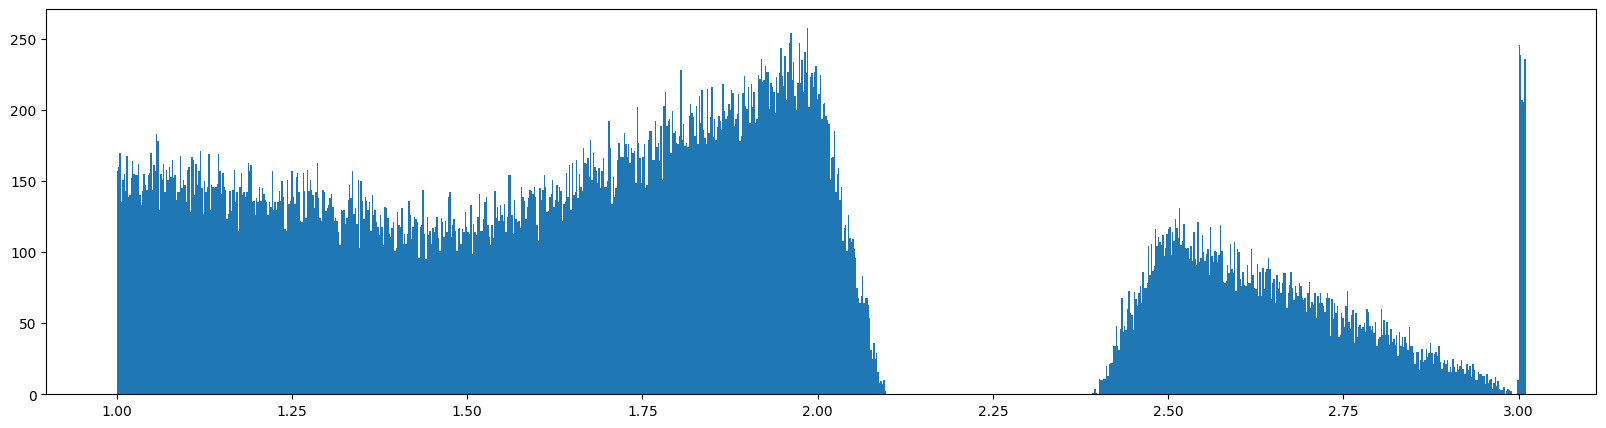

In [11]:
# Plot histogram of the samples.
plt.hist(samples, bins=1000);

## Time Usage

In [12]:
%%timeit
rand_from_cdf(rng=rng, cdf_points=cdf_points, cdf_values=cdf_values, size=size)

5.47 ms ± 33.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## License (MIT)

This is published under the [MIT License](https://github.com/Hvass-Labs/Code-Recipes/blob/main/LICENSE) which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/Hvass-Labs/Code-Recipes).